# Keras, KNN, RandomForest, and Pytorch

In [1]:
import tensorflow as tf
from tensorflow import keras

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
torch.set_grad_enabled(True)
torch.set_printoptions(linewidth =120)

import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
import timeit
# start_time = timeit.default_timer()
# code you want to evaluate
# elapsed = timeit.default_timer() - start_time

In [3]:
def confusion_matrix(cm, names, title='Confusion Matrix Actual vs. Predicted', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

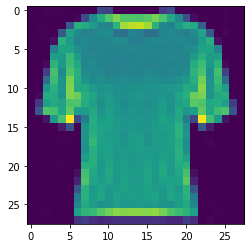

In [4]:
#Load Data
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#Example of image
plt.imshow(x_train[825])

In [5]:
#Define labels
fashion_mnist_labels = ["T-shirt",  
                        "Trouser",      
                        "Pullover",     
                        "Dress",        
                        "Coat",         
                        "Sandal",       
                        "Shirt",         
                        "Sneaker",      
                        "Bag",          
                        "Boots"]   

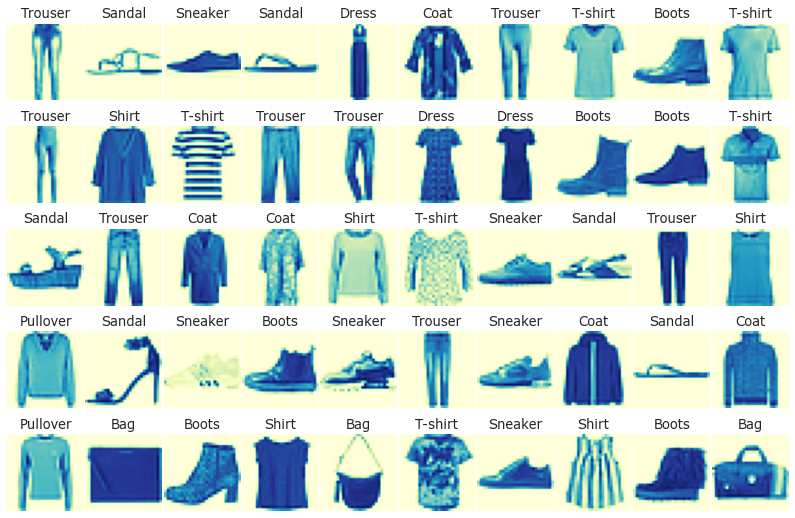

In [6]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Boots',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap='YlGnBu')

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

sample_size = 50
rand_indexes = np.random.randint(0, len(x_train), sample_size)
sample_images = x_train[rand_indexes]
sample_labels = y_train[rand_indexes]
display_sample(sample_images, sample_labels)

# CNN Model: Keras

Leveraged code from Medium article <i> Fashion-MNIST with tf.Keras </i> written by Margaret Maynard-Reid 

https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a

In [7]:
#Normalize Data so that they are of approximately the same scale
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Clean data to allow for keras analysis

In [8]:
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Define model layers

In [9]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint


start_time = timeit.default_timer()

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

elapsed = timeit.default_timer() - start_time

Epoch 1/10
859/860 [============================>.] - ETA: 0s - loss: 0.6105 - accuracy: 0.7755
Epoch 00001: val_loss improved from inf to 0.39218, saving model to model.weights.best.hdf5
860/860 [==============================] - 25s 29ms/step - loss: 0.6105 - accuracy: 0.7755 - val_loss: 0.3922 - val_accuracy: 0.8658
Epoch 2/10
859/860 [============================>.] - ETA: 0s - loss: 0.4179 - accuracy: 0.8482
Epoch 00002: val_loss improved from 0.39218 to 0.32877, saving model to model.weights.best.hdf5
860/860 [==============================] - 26s 30ms/step - loss: 0.4178 - accuracy: 0.8483 - val_loss: 0.3288 - val_accuracy: 0.8840
Epoch 3/10
859/860 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.8631
Epoch 00003: val_loss improved from 0.32877 to 0.30158, saving model to model.weights.best.hdf5
860/860 [==============================] - 26s 30ms/step - loss: 0.3736 - accuracy: 0.8631 - val_loss: 0.3016 - val_accuracy: 0.8888
Epoch 4/10
859/860 [=========

In [12]:
score_cnn = model.evaluate(x_test, y_test, verbose=0)

print('\n', 'elapsed time:', elapsed)
print('\n', 'accuracy:', score_cnn[1])


 elapsed time: 257.8990596

 accuracy: 0.9100000262260437


Convolutional Neural Network Report


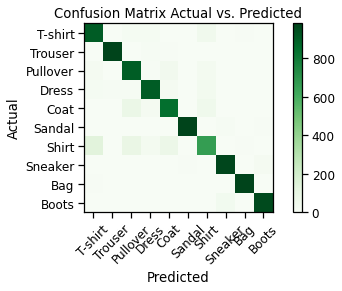

In [13]:
cnn = model.predict(x_test)
cnn = np.argmax(cnn,axis=1)
y_actual = np.argmax(y_test,axis=1)

cnn_cm_mnist = metrics.confusion_matrix(y_actual, cnn)
print("Convolutional Neural Network Report")

plt.figure()
confusion_matrix(cnn_cm_mnist, fashion_mnist_labels)
plt.show()

# Random Forest

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

Random Forest Model 1

In [17]:
start_time = timeit.default_timer()

rf = RandomForestClassifier(criterion='entropy', max_depth=30)
rf.fit(x_train, y_train)

elapsed = timeit.default_timer() - start_time

In [18]:
rf_pred = rf.predict(x_test)
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)

print('\n', 'elapsed time:', elapsed)
print("Accuracy score: {}".format(rf_accuracy))


 elapsed time: 76.35657070000002
Accuracy score: 0.878


Random Forest Model 2

In [19]:
start_time = timeit.default_timer()

rf = RandomForestClassifier(criterion='gini', max_depth=30)
rf.fit(x_train, y_train)

elapsed = timeit.default_timer() - start_time

In [20]:
rf_pred = rf.predict(x_test)
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)

print('\n', 'elapsed time:', elapsed)
print("Accuracy score: {}".format(rf_accuracy))


 elapsed time: 67.86263629999996
Accuracy score: 0.8747


Random Forest Model 3

In [21]:
start_time = timeit.default_timer()

rf = RandomForestClassifier(criterion='entropy', max_depth=None)
rf.fit(x_train, y_train)

elapsed = timeit.default_timer() - start_time

In [22]:
rf_pred = rf.predict(x_test)
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)

print('\n', 'elapsed time:', elapsed)
print("Accuracy score: {}".format(rf_accuracy))


 elapsed time: 77.07616200000007
Accuracy score: 0.8762


Random Forest


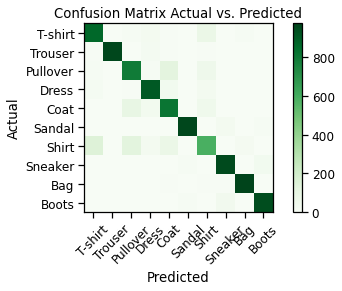

In [23]:
# Random Forest report and analysis

rf_cm = metrics.confusion_matrix(y_test, rf_pred)
print("Random Forest")

plt.figure()
confusion_matrix(rf_cm, fashion_mnist_labels)
plt.show()

# K Nearest Neighbor

KNN Model 1

In [24]:
start_time = timeit.default_timer()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

elapsed = timeit.default_timer() - start_time

In [25]:
knn_pred = knn.predict(x_test)
knn_accuracy = metrics.accuracy_score(y_test, knn_pred)

print('\n', 'elapsed time:', elapsed)
print("Accuracy score: {}".format(knn_accuracy))


 elapsed time: 18.887284200000067
Accuracy score: 0.8554


KNN Model 2

In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [27]:
start_time = timeit.default_timer()

knn_pred = knn.predict(x_test)
knn_accuracy = metrics.accuracy_score(y_test, knn_pred)

elapsed = timeit.default_timer() - start_time

print('\n', 'elapsed time:', elapsed)
print("Accuracy score: {}".format(knn_accuracy))


 elapsed time: 523.8381766000002
Accuracy score: 0.8541


K Nearest Neighbor


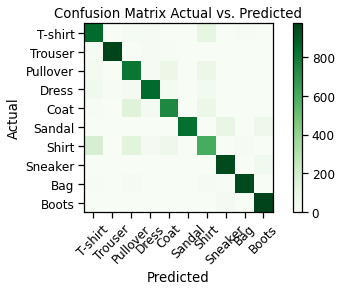

In [28]:
# Random Forest report and analysis

knn_cm = metrics.confusion_matrix(y_test, knn_pred)
print("K Nearest Neighbor")

plt.figure()
confusion_matrix(knn_cm, fashion_mnist_labels)
plt.show()

# CNN Model: Pytorch

Leveraged code from Kaggle post <i> Fashion MNIST with Pytorch </i> written by Pankaj Joshi

https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy

In [209]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [210]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
a = next(iter(train_loader))
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

In [211]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [212]:
model = FashionCNN()

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [213]:
start_time = timeit.default_timer()

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 // total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

elapsed = timeit.default_timer() - start_time
print('\n', 'elapsed time:', elapsed)

Iteration: 500, Loss: 0.48215094208717346, Accuracy: 87%
Iteration: 1000, Loss: 0.33429375290870667, Accuracy: 89%
Iteration: 1500, Loss: 0.3432767391204834, Accuracy: 88%
Iteration: 2000, Loss: 0.20704509317874908, Accuracy: 88%
Iteration: 2500, Loss: 0.13984020054340363, Accuracy: 89%
Iteration: 3000, Loss: 0.2067953497171402, Accuracy: 91%

 elapsed time: 405.3803110000008


In [214]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt: 89.50%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 80.40%
Accuracy of Dress: 94.10%
Accuracy of Coat: 87.80%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 69.20%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 99.10%
Accuracy of Boots: 96.80%
